# Bayesian Online Changepoint Detection
* It is a probabilistic model to identify the level shifts(mean-shifts) or variational shifts in incoming dataset
* It predicts posterior probability of run length(interval between to changepoints in dataset) so for a dataset of n-samples, there are n-possible run lengths.
* The model calculates probability that all those possible run lengths for each datapoint to be changepoints so it creates $NxN$ matrix where $N$ is length of the dataset
* So we set default threshold probability for it be a changepoint is $0.5$.

## Required Arguments to run the program:

* All of the algorithm related parameters are optional which has a default value given in the program itself.
* Description for each argument is given below :

* algo_kwargs={
            'is_train':Takes Boolean argument true or false, true for model which requires training,
            'data_col_index':1  -> column index from which metrics to be considered for anomaly detection ,
            'pthres':thres_prob -> probability after which a point is considered as changepoint,
            'Nw':samples_to_wait -> samples to wait before detecting changepoints,
            'mean_runlen':expected_run_length -> average run length between two change points in dataset
        }
        
* So the default value given are as follows:
     * algo_kwargs={
            'is_train':False,
            'data_col_index':1,
            'pthres':0.5,
            'Nw':10,
            'mean_runlen':100
        }

## Dependencies :
* Download https://github.com/hildensia/bayesian_changepoint_detection this and run **python setup.py install** to install the bayesian changepoint detection module.
* Install **psycopg2** module using pip to connect to postgresql db
* Install **writefile_run** using pip , which is used to save the cell in a python file automatically

In [1]:
import writefile_run as writefile_run

In [2]:
filename = '../../anomaly_detectors/bayesian_detector/bayeschangept_wrapper.py'

In [3]:
%%writefile_run $filename

'''
importing all the required header files
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os

# Importing reader and checker python files as modules
from anomaly_detectors.reader_writer import db_properties as db_props
from anomaly_detectors.reader_writer import writer_configs as write_args

import psycopg2

from anomaly_detectors.utils.preprocessors import *
from anomaly_detectors.utils.data_handler import *
# from anomaly_detectors.bayesian_detectorbayesian_changept_detector import *

from anomaly_detectors.utils import error_codes as error_codes
from anomaly_detectors.utils import type_checker as type_checker
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.utils import reader_helper
from anomaly_detectors.utils import make_ackg_json
from anomaly_detectors.bayesian_detector import bayesian_changept_detector

import json
import traceback
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

Use scipy logsumexp().


In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
%%writefile_run $filename -a

'''
ideal argument types for algorithm
'''
algo_params_type ={
            'data_col_index':int,
            'pthres':float or int,
            'Nw':int,
            'mean_runlen':int,
            'to_plot':bool
        }

mode_options = ['DETECT','LOG','DETECT_LOG']

In [6]:
%%writefile_run $filename -a


def main(json_data,mode=mode_options[2],thres_prob=0.5,samples_to_wait=10,expected_run_length=100,to_plot=True):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in reader args and parses json 
                            and gives dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        It takes reader args as of now to get the dataset and algo related arguments
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        

        #algorithm arguments
        algo_kwargs={
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length,
            'to_plot':to_plot
        }
                    
        try: 
            '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
            '''
            
            error_codes.reset()
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=algo_params_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return res
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = pd.unique(data_per_asset['assetno'])[0]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])
                    

                    for data_col in range(1,len(data_per_asset.columns[1:])+1):
                        algo_kwargs['data_col_index'] = data_col
                        print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,
                                                                                             data_per_asset.columns[data_col]))
                        anomaly_detector = bayesian_changept_detector.Bayesian_Changept_Detector(data_per_asset,
                                                                                                 assetno=assetno,
                                                                                                 **algo_kwargs)
                        data,anom_indexes = anomaly_detector.detect_anomalies()
                        
                            
                        sql_query_args = write_args.writer_kwargs
                        table_name = write_args.table_name
                        window_size = 10

                        anomaly_detectors.append(anomaly_detector)
                        
                
                
                out_json = {}
                
                if(mode==mode_options[0] or mode==mode_options[2]):
                    ack_json = make_ackg_json.make_ack_json(anomaly_detectors)
                    out_json['ack_json'] = ack_json
                if(mode==mode_options[1] or mode==mode_options[2]):
                    '''
                    Instantiates writer class to write into local database with arguments given below
                    Used for Bulk writing
                    '''
                    writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                            table_name=table_name,window_size=window_size)

                    #called for mapping args before writing into db
                    res = writer.map_outputs_and_write()
                    out_json['log_json']=res
               
                return json.dumps(out_json)
            else:
                '''
                Data empty error
                '''
                return json.dumps(error_codes.error_codes['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes.error_codes['unknown']['message']=e
            return json.dumps(error_codes.error_codes['unknown'])

In [7]:
# %%writefile_run bayeschangept_sprint1.py -a
'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['TSFAD_A1']
con = '192.168.2.5:4242'
src_type =  'opentsdb'
param = ['ec2_cpu_utilization_5f5533']
from_timestamp = 1392388020
to_timestamp = 1393597320

In [8]:
reader_kwargs = lambda :{
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True}

algo_kwargs =lambda: {
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100,
            'to_plot':True
        }

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : TSFAD_A1 , Metric : ec2_cpu_utilization_5f5533
 
Shape of the dataset : 
(4032, 2)


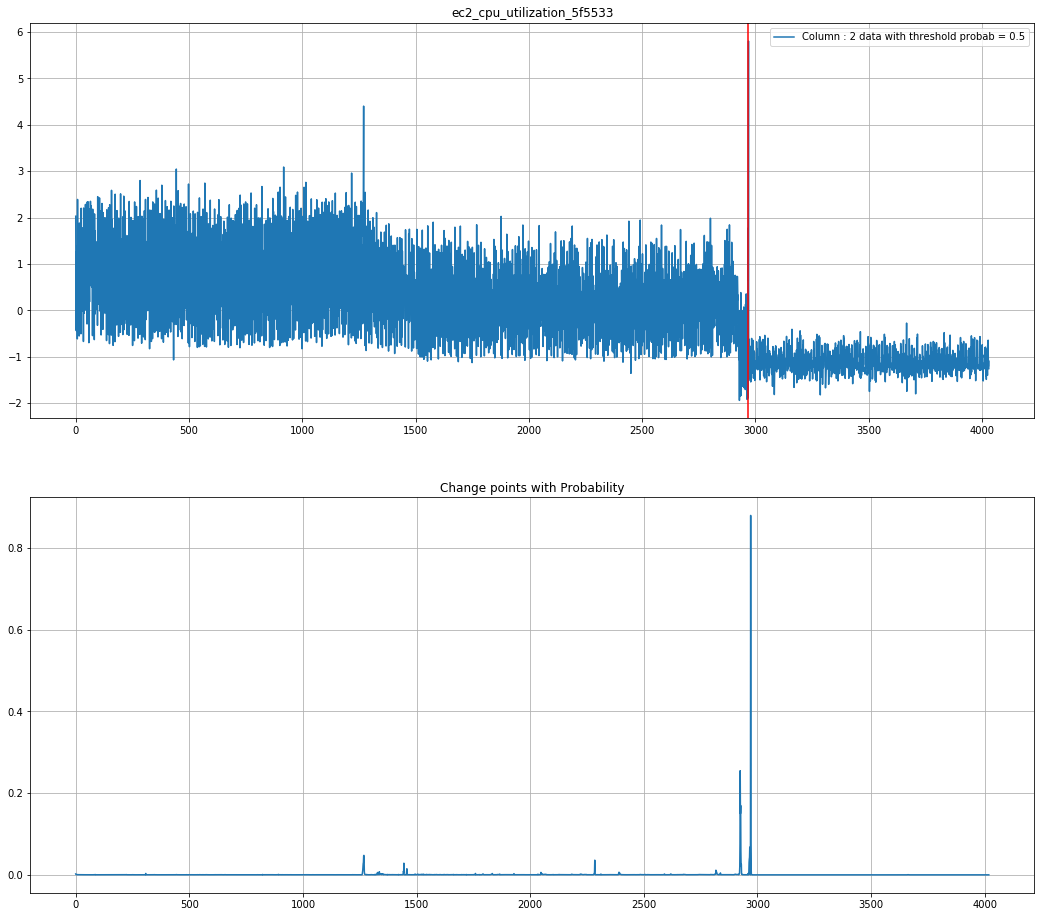


 No of Anomalies detected = 1
Postgres writer initialised 


 Successfully written into database

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "ec2_cpu_utilization_5f5533", "datapoints": [[1393279020000, 1393279020000]]}]}]}, "log_json": {"code": "200", "status": "OK"}}


In [9]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints and writing
to database
'''

reader_kwargs1 = reader_kwargs()
algo_kwargs1 = algo_kwargs()
json_data = reader_helper.read(reader_kwargs1)
res = main(**algo_kwargs1,json_data=json_data)
print(res)

## Testing the algo on sample csv datasets


Detecting anomalies for alcohol-demand-log-spirits-consu.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : Alcohol demand (log spirits consumption per head), UK, 1870-1938
 
Shape of the dataset : 
(207, 2)


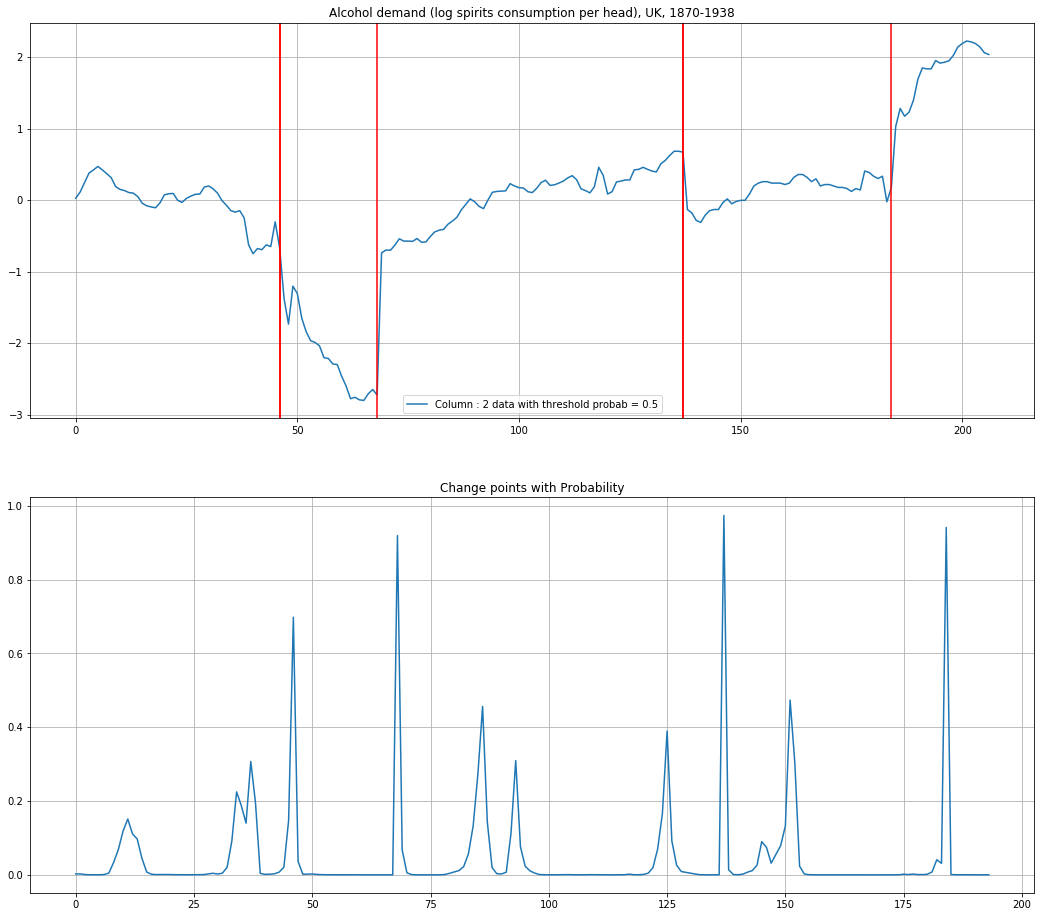


 No of Anomalies detected = 6
Postgres writer initialised 


 Successfully written into database

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Alcohol demand (log spirits consumption per head), UK, 1870-1938", "datapoints": [[-2663971200000.0, -2663971200000.0], [-2663971200000.0, -2663971200000.0], [-2432505600000.0, -2432505600000.0], [-1706832000000.0, -1706832000000.0], [-1706832000000.0, -1706832000000.0], [-1212451200000.0, -1212451200000.0]]}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for average-annual-temperature-centr.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : Average annual temperature, central England, 1723 ? 1970
 
Shape of the dataset : 
(248, 2)


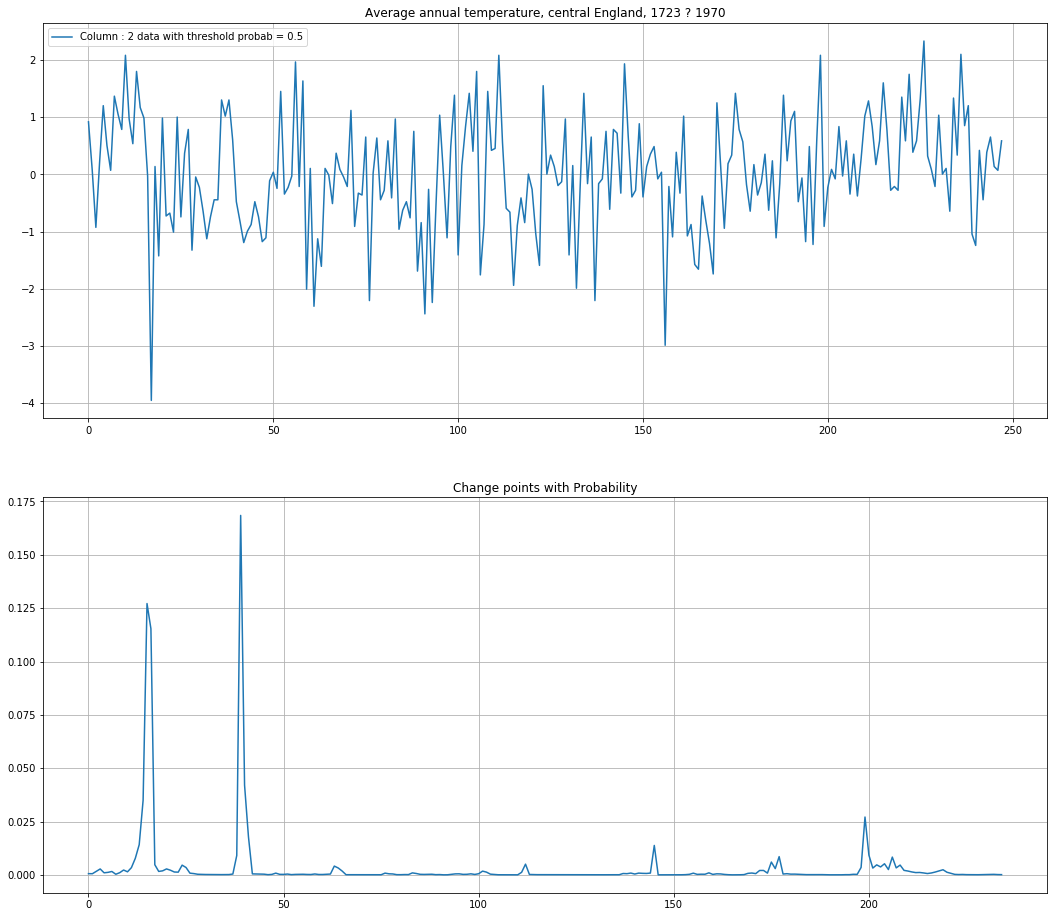


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Average annual temperature, central England, 1723 ? 1970", "datapoints": []}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for mean-monthly-temperature-1907-19.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : Mean monthly temperature, 1907 ? 1972
 
Shape of the dataset : 
(792, 2)


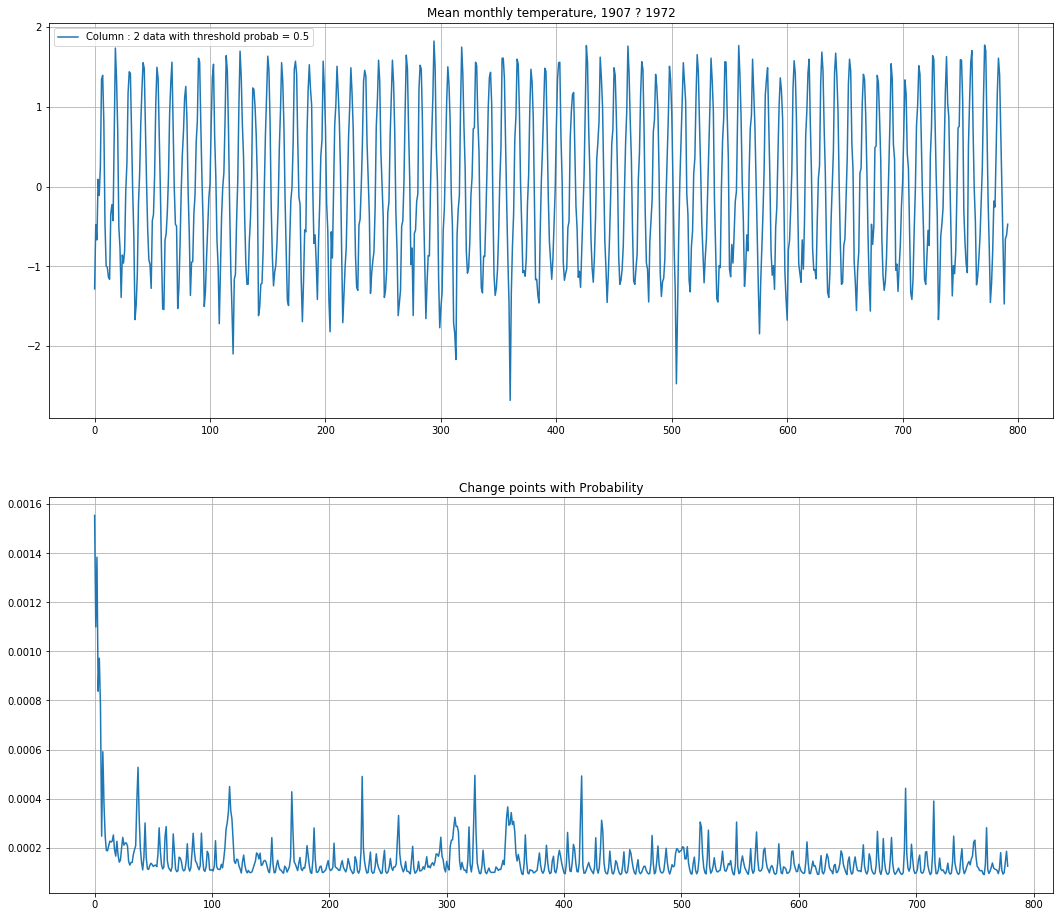


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Mean monthly temperature, 1907 ? 1972", "datapoints": []}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : CO2
 
Shape of the dataset : 
(296, 3)


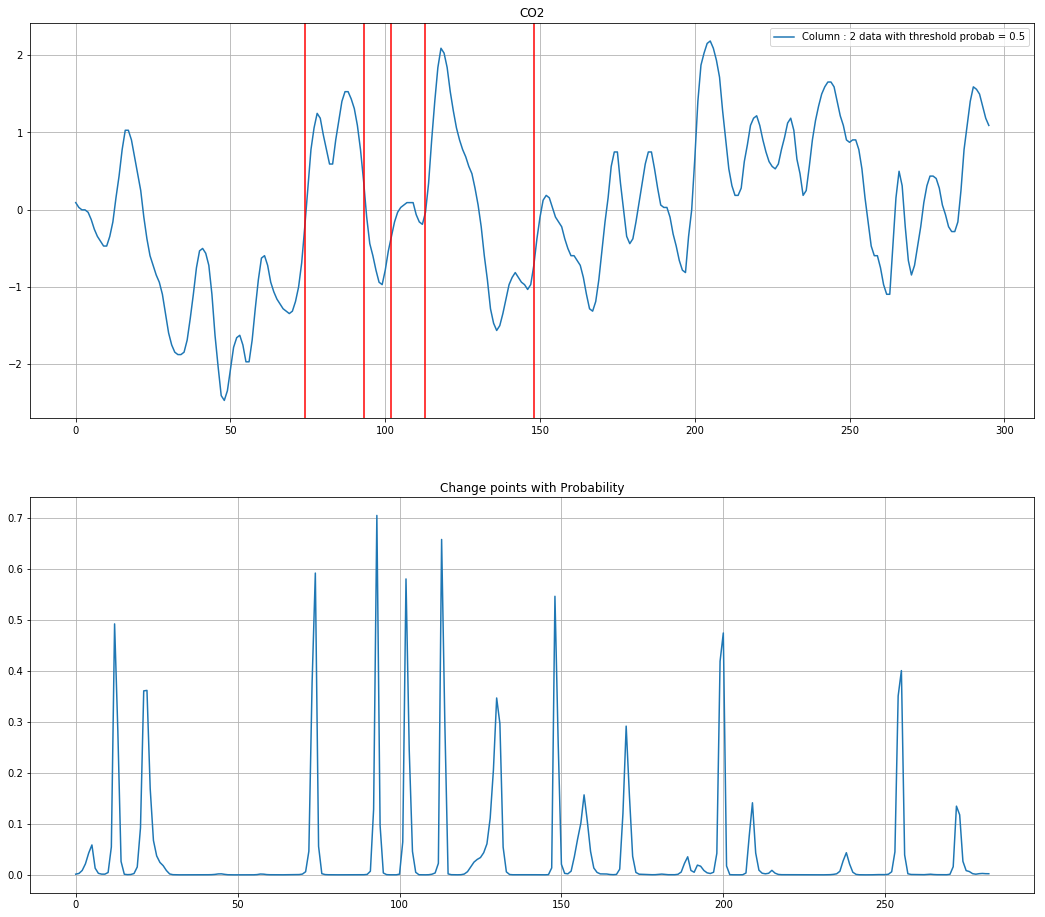


 No of Anomalies detected = 5

Anomaly detection for AssetNo : 1.0 , Metric : Methane
 
Shape of the dataset : 
(296, 3)


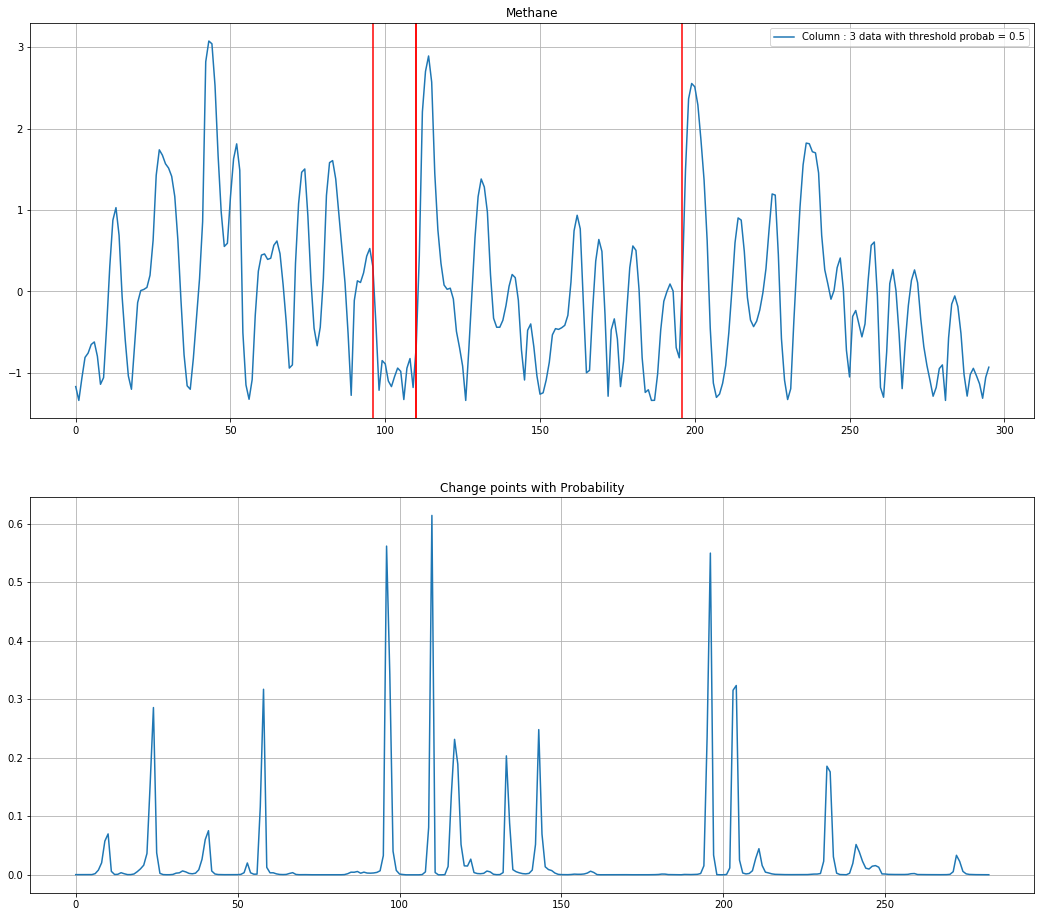


 No of Anomalies detected = 4
Postgres writer initialised 


 Successfully written into database

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "CO2", "datapoints": [[7848360000000.0, 7848360000000.0], [7858620000000.0, 7858620000000.0], [7863480000000.0, 7863480000000.0], [7869420000000.0, 7869420000000.0], [7888320000000.0, 7888320000000.0]]}, {"name": "Methane", "datapoints": [[7860240000000.0, 7860240000000.0], [7867800000000.0, 7867800000000.0], [7867800000000.0, 7867800000000.0], [7914240000000.0, 7914240000000.0]]}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981
 
Shape of the dataset : 
(408, 2)


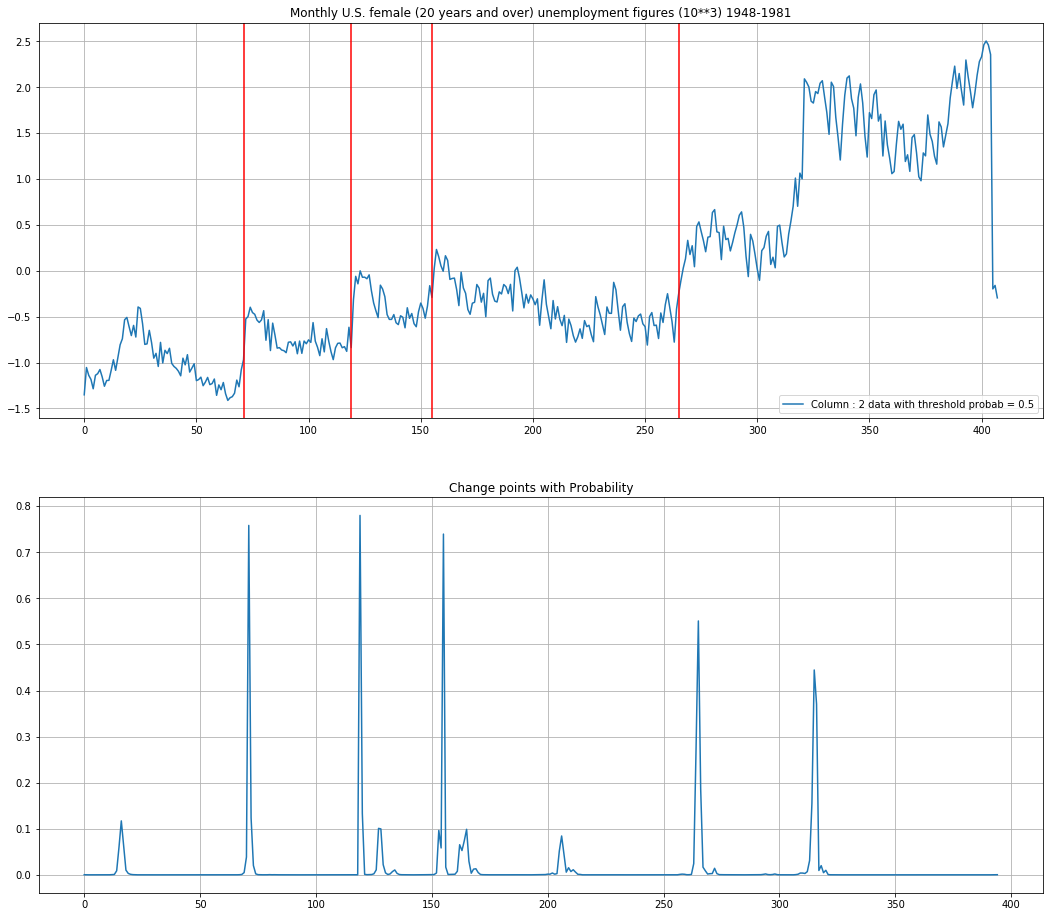


 No of Anomalies detected = 4
Postgres writer initialised 


 Successfully written into database

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981", "datapoints": [[-507600000000.0, -507600000000.0], [-381369600000.0, -381369600000.0], [-286675200000.0, -286675200000.0], [10368000000.0, 10368000000.0]]}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for winter-negative-temperature-sum-.csv

Data reader initialised 

Getting the dataset from the reader....


Anomaly detection for AssetNo : 1.0 , Metric : Winter negative temperature sum (in deg. C), 1781 ? 1988
 
Shape of the dataset : 
(208, 2)


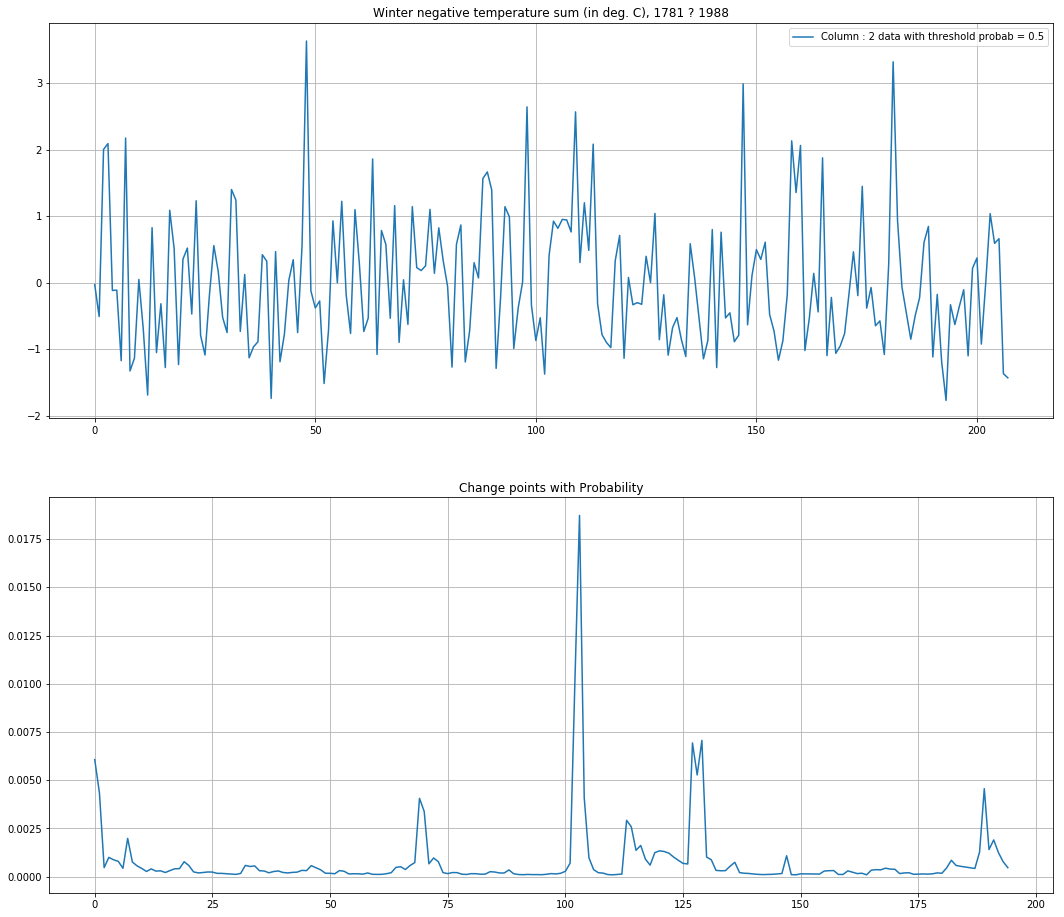


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Winter negative temperature sum (in deg. C), 1781 ? 1988", "datapoints": []}]}]}, "log_json": {"code": "200", "status": "OK"}}


In [10]:
data_dir = '../../dataset/sample_csv_files/'
target_dir = '../../dataset/reader_csv_files/'
assetno = ['1']
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    
    reader_kwargs1 = csv_helper.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    
    json_data  = reader_helper.read(reader_kwargs1)
    algo_kwargs1 = algo_kwargs()
    algo_kwargs1['expected_run_length'] = 250
    
#     print('params: {}\n'.format(param))
   
    res = main(**algo_kwargs1,json_data=json_data)
    print(res)

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets